In [ ]:
# Комар Софія | завдання 3 - оптимізація гіперпараметрів моделі нейронної мережі

# https://github.com/soviio/komar_sofiia_deep_learning/tree/main

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from sklearn.metrics import f1_score
import os
import shutil
from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
# GPU
print("CUDA:", torch.cuda.is_available())

CUDA: True


**для зручності виводжу резельтати попередньої домашки**

In [44]:
# реалізація простої архітектури CNN

class CNNModel(nn.Module):
    def __init__(self, num_classes=6):
        super(CNNModel, self).__init__()

        # перший згортковий шар + Max Pooling
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # другий згортковий шар + Max Pooling
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # третій згортковий шар + Max Pooling
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # повнозв'язані шари
        self.fc1 = nn.Linear(128 * 18 * 18, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)  # вихідний

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 150 → 75
        x = self.pool(F.relu(self.conv2(x)))  # 75 → 37
        x = self.pool(F.relu(self.conv3(x)))  # 37 → 18

        x = torch.flatten(x, 1)  # у вектор
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Softmax

        return x

model = CNNModel()
print(model)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=41472, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=6, bias=True)
)


In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=41472, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=6, bias=True)
)

In [46]:
x = torch.randn(1, 3, 150, 150).to(device)
output = model(x)
print(output.shape)  #  [1, 6]

torch.Size([1, 6])


In [47]:
# налаштування функції втрат і оптимізатора

criterion = nn.CrossEntropyLoss()  # categorical crossentropy
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Adam optimizer
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) # learning Rate Scheduler
print(model)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=41472, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=6, bias=True)
)


In [52]:
# тренування моделі на невеликій кількості епох

data_dir = "/content/drive/MyDrive/seg_train/seg_train"
test_dir = "/content/drive/MyDrive/seg_test/seg_test"

def is_valid_file(path):
    return ".ipynb_checkpoints" not in path.lower()

transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

class CustomImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            return super(CustomImageFolder, self).__getitem__(index)
        except (OSError, IOError) as e:
            print(f"Error with image {self.imgs[index][0]}: {e}")
            return None


train_dataset = CustomImageFolder(root=data_dir, transform=transform, is_valid_file=is_valid_file)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform, is_valid_file=is_valid_file)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# DataLoaders
batch_size = 32
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"К-сть train-зразків -> {len(train_data)}")
print(f"К-сть validation-зразків -> {len(val_data)}")
print(f"К-сть test-зразків -> {len(test_dataset)}")

for images, labels in train_loader:
    print(f"Батч розміру {images.size()}, мітки: {labels}")
    break

К-сть train-зразків -> 11227
К-сть validation-зразків -> 2807
К-сть test-зразків -> 3000
Батч розміру torch.Size([32, 3, 150, 150]), мітки: tensor([5, 1, 4, 1, 5, 2, 2, 5, 4, 2, 5, 2, 1, 2, 3, 2, 2, 3, 0, 5, 0, 0, 3, 4,
        0, 2, 2, 0, 5, 0, 4, 3])


In [53]:
print(torch.cuda.is_available())  # True - GPU доступний
print(torch.cuda.get_device_name(0))

True
Tesla T4


In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 20
train_losses, val_losses, train_acc, val_acc = [], [], [], []

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:

        images = images.to(device).float()
        labels = labels.to(device).long()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_acc.append(correct / total)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # GPU
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    val_acc.append(correct / total)

    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}, F1-score: {f1:.4f}")

Epoch 1/20, Train Loss: 1.0045, Train Acc: 0.6125, Val Loss: 0.8711, Val Acc: 0.6662, F1-score: 0.6639
Epoch 2/20, Train Loss: 0.8719, Train Acc: 0.6707, Val Loss: 0.7465, Val Acc: 0.7228, F1-score: 0.7256
Epoch 3/20, Train Loss: 0.7730, Train Acc: 0.7131, Val Loss: 0.7173, Val Acc: 0.7339, F1-score: 0.7290
Epoch 4/20, Train Loss: 0.7131, Train Acc: 0.7314, Val Loss: 0.6769, Val Acc: 0.7421, F1-score: 0.7396
Epoch 5/20, Train Loss: 0.6528, Train Acc: 0.7641, Val Loss: 0.6198, Val Acc: 0.7716, F1-score: 0.7711
Epoch 6/20, Train Loss: 0.5995, Train Acc: 0.7788, Val Loss: 0.5969, Val Acc: 0.7777, F1-score: 0.7796
Epoch 7/20, Train Loss: 0.5662, Train Acc: 0.7926, Val Loss: 0.5468, Val Acc: 0.8009, F1-score: 0.8024
Epoch 8/20, Train Loss: 0.5245, Train Acc: 0.8064, Val Loss: 0.5201, Val Acc: 0.8158, F1-score: 0.8168
Epoch 9/20, Train Loss: 0.4870, Train Acc: 0.8211, Val Loss: 0.5167, Val Acc: 0.8140, F1-score: 0.8144
Epoch 10/20, Train Loss: 0.4561, Train Acc: 0.8347, Val Loss: 0.5277, Val

**нижче реалізована ручна оптимізація (словники параметрів)**

In [58]:
# золоті параметри - Learning Rate, Batch Size та Epochs, але мені не вистачає потужності
# пристрою на перевірку всіх комбінацій, відповідно розгляну лише Learning Rate

# дуже багато часу займає реалізація перевірки комбінацій золотих параметрів - запускала відповідний код, але
# не отримала результатів - припускаю, справа у потужності пристрою :(

learning_rates = [0.001, 0.0001, 0.01]
results_lr = {}

for lr in learning_rates:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    train_losses, val_losses, train_acc, val_acc = [], [], [], []

    for epoch in range(10):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device).float(), labels.to(device).long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_acc.append(correct / total)

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device).float(), labels.to(device).long()
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(val_loader))
        val_acc.append(correct / total)

        scheduler.step()

    results_lr[lr] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_acc': train_acc,
        'val_acc': val_acc
    }

print(results_lr)

{0.001: {'train_losses': [0.07911679654406055, 0.049127481944531176, 0.05215929957958929, 0.04141383476756545, 0.04407587316056529, 0.04277319423883787, 0.03258459464101656, 0.04627200119969263, 0.03134021382270851, 0.0413552758121935], 'val_losses': [1.2620595098388465, 1.4055565629493108, 1.0746928876773878, 1.251619682054628, 1.259967402639714, 1.0002193878489463, 1.0800548197532243, 1.2393195700239052, 1.221413701137697, 1.101470004343851], 'train_acc': [0.9781776075532199, 0.9870847065110894, 0.9856595706778303, 0.9869956355215106, 0.9881535583860337, 0.9875300614589828, 0.9900240491671862, 0.9864612095840385, 0.9913601140108667, 0.9877972744277189], 'val_acc': [0.823655147844674, 0.8147488421802637, 0.8229426433915212, 0.8265051656572854, 0.8240114000712504, 0.8275739223370147, 0.8286426790167438, 0.8222301389383684, 0.8265051656572854, 0.8257926612041325]}, 0.0001: {'train_losses': [0.02004819993683142, 0.018609592600702277, 0.014395036558909897, 0.017224864489227335, 0.01216059

In [59]:
results_lr

{0.001: {'train_losses': [0.07911679654406055,
   0.049127481944531176,
   0.05215929957958929,
   0.04141383476756545,
   0.04407587316056529,
   0.04277319423883787,
   0.03258459464101656,
   0.04627200119969263,
   0.03134021382270851,
   0.0413552758121935],
  'val_losses': [1.2620595098388465,
   1.4055565629493108,
   1.0746928876773878,
   1.251619682054628,
   1.259967402639714,
   1.0002193878489463,
   1.0800548197532243,
   1.2393195700239052,
   1.221413701137697,
   1.101470004343851],
  'train_acc': [0.9781776075532199,
   0.9870847065110894,
   0.9856595706778303,
   0.9869956355215106,
   0.9881535583860337,
   0.9875300614589828,
   0.9900240491671862,
   0.9864612095840385,
   0.9913601140108667,
   0.9877972744277189],
  'val_acc': [0.823655147844674,
   0.8147488421802637,
   0.8229426433915212,
   0.8265051656572854,
   0.8240114000712504,
   0.8275739223370147,
   0.8286426790167438,
   0.8222301389383684,
   0.8265051656572854,
   0.8257926612041325]},
 0.0001: 

In [60]:
max_val_acc = {}
for lr, data in results_lr.items():
    max_val_acc[lr] = max(data['val_acc'])

best_lr = max(max_val_acc, key=max_val_acc.get)
best_val_acc = max(max_val_acc.values())

print(best_lr)

0.0001


**далі змінюємо кількість нейронів у повнозв'язаних шарах та кількість
згорткових шарів**

In [ ]:
class CNNModel1(nn.Module):
    def __init__(self, num_classes=6):
        super(CNNModel1, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # додатковий згортковий шар + Max Pooling
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        # початковий розмір: 128x128
        # 4 операції з MaxPooling з розміром 2x2, що зменшує розмір вдвічі кожного разу
        self.fc1 = nn.Linear(256 * 8 * 8, 512)  # зміна кількості нейронів, враховуючи новий розмір
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)  # зміна кількості нейронів
        self.fc3 = nn.Linear(256, num_classes)  # вихідний

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 128 → 64
        x = self.pool(F.relu(self.conv2(x)))  # 64 → 32
        x = self.pool(F.relu(self.conv3(x)))  # 32 → 16
        x = self.pool(F.relu(self.conv4(x)))  # 16 → 8

        x = torch.flatten(x, 1)  # у вектор
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Softmax

        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = "/content/drive/MyDrive/seg_train/seg_train"
test_dir = "/content/drive/MyDrive/seg_test/seg_test"

train_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f"Classes: {train_dataset.classes}")

model1 = CNNModel1(num_classes=len(train_dataset.classes))
model1.to(device)
optimizer = optim.Adam(model1.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# масштабування градієнтів для mixed-precision training (для GPU)
from torch.cuda.amp import GradScaler, autocast
scaler = GradScaler() # можливо, зайве, але значно пришвидшує код і покращує саме тренування

epochs = 10
for epoch in range(epochs):
    model1.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model1(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {correct/total:.4f}")

model1.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model1(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {correct/total:.4f}")

Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


<ipython-input-94-ed5c4e28e9bc>:86: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-94-ed5c4e28e9bc>:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Loss: 0.9684, Accuracy: 0.6248
Epoch 2/10, Loss: 0.6345, Accuracy: 0.7740
Epoch 3/10, Loss: 0.4986, Accuracy: 0.8226
Epoch 4/10, Loss: 0.4240, Accuracy: 0.8497
Epoch 5/10, Loss: 0.3618, Accuracy: 0.8699
Epoch 6/10, Loss: 0.3129, Accuracy: 0.8875
Epoch 7/10, Loss: 0.2464, Accuracy: 0.9136
Epoch 8/10, Loss: 0.2288, Accuracy: 0.9206


In [ ]:
# отже, додавання додаткового згорткового шару покращило результати моделі, але
# мені видало ʼзауваженняʼ, що ліміт на cpu/cuda вичерпан, відповідно код зупинився на 8 епосі

# надалі створю словники з результатами, які я отримала вище для візуалізацій, оскільки відбулось відʼєднання
# від віддаленого середовища виконання (ліміт на cpu/cuda вичерпан)

**Автоматизована оптимізація Optuna +  крос-валідація**

In [4]:
!pip install optuna

In [ ]:
# наново підвʼязую бібілотеки та дані, бо після проблеми з лімітом на cpu/coda код вище треба запускати по новій

# вимушена спрощувати параметри для того, щоб пришвидшити реалізацію:
# кількість фолдів у KFold: 3 фолди, бо зменшує час на крос-валідацію
# спроб в Optuna: 5 спроб замість 10, щоб зменшити час для пошуку найкращих гіперпараметрів.
# епох: до 3-5 епох - значно зменшує час тренування

# на жаль, наразі кращого вирішення проблеми не придумала

In [5]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn.functional as F
from sklearn.model_selection import KFold

class CNNModel(nn.Module):
    def __init__(self, num_classes=6, dropout_rate=0.5):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#  тренування та оптимізація з крос-валідацією
def objective(trial):
    batch_size = trial.suggest_int('batch_size', 16, 32, step=16)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
    epochs = trial.suggest_int('epochs', 3, 5)  #  3-5 епох

    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    data_dir = "/content/drive/MyDrive/seg_train/seg_train"
    test_dir = "/content/drive/MyDrive/seg_test/seg_test"
    train_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

    #  KFold для крос-валідації (3 для швидшого виконання)
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    val_accuracies = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for train_index, val_index in kf.split(train_dataset):
        train_subsample = torch.utils.data.Subset(train_dataset, train_index)
        val_subsample = torch.utils.data.Subset(train_dataset, val_index)

        train_loader = DataLoader(train_subsample, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subsample, batch_size=batch_size, shuffle=False)

        model = CNNModel(num_classes=6, dropout_rate=dropout_rate).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        for epoch in range(epochs):
            model.train()
            running_loss, correct, total = 0.0, 0, 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        val_accuracies.append(val_acc)
    return sum(val_accuracies) / len(val_accuracies)

# Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)  # 5 спроб

print("Best hyperparameters found: ", study.best_params)
print("Best validation accuracy: ", study.best_value)

[I 2025-03-25 15:33:31,900] A new study created in memory with name: no-name-5834ee10-6942-4523-bd6b-8856d2906b8b
<ipython-input-5-7822ab5dc04e>:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-5-7822ab5dc04e>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
[I 2025-03-25 17:01:22,344] Trial 0 finished with value: 0.7997719823286303 and parameters: {'batch_size': 16, 'lr': 0.0003729198296112779, 'dropout_rate': 0.4626874540986205, 'epochs': 3}. Best is trial 0 with value: 0.7997719823286303.
[I 2025-03-25 17:09:13,204] Trial 1 finished with value: 0.778822858771

Best hyperparameters found:  {'batch_size': 32, 'lr': 0.00047292309146958753, 'dropout_rate': 0.27264523185946954, 'epochs': 4}
Best validation accuracy:  0.8060424682912926


**Оцінка продуктивності моделі**

In [8]:
best_params = study.best_params # знайдені гіперпараметри після виконання Optuna

batch_size = best_params['batch_size']
lr = best_params['lr']
dropout_rate = best_params['dropout_rate']
epochs = best_params['epochs']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

data_dir = "/content/drive/MyDrive/seg_train/seg_train"
test_dir = "/content/drive/MyDrive/seg_test/seg_test"
train_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
model = CNNModel(num_classes=6, dropout_rate=dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {correct/total:.4f}")

model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

Epoch 1/4, Loss: 1.0013, Accuracy: 0.6067
Epoch 2/4, Loss: 0.7163, Accuracy: 0.7314
Epoch 3/4, Loss: 0.5439, Accuracy: 0.8044
Epoch 4/4, Loss: 0.4448, Accuracy: 0.8404


Test Accuracy: 0.8443
F1-score: 0.8463


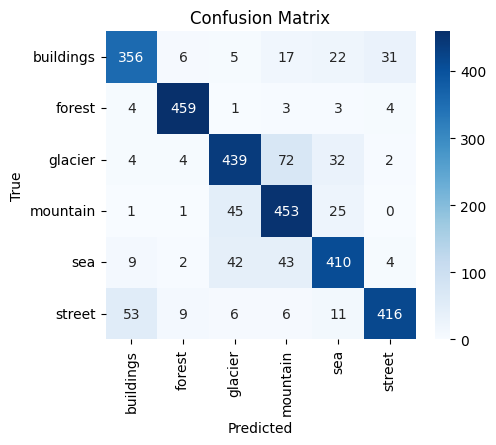

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

test_accuracy = correct / total
f1 = f1_score(all_labels, all_preds, average='macro')
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1-score: {f1:.4f}")

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_loader.dataset.classes, yticklabels=train_loader.dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Порівняння результатів**

Порівнювати буду наступні реалізації:
1. модель, реалізована у попередній домашці (**MODEL №1**)

*   тренувальна точність: стабільне зростання точності - 94% після 20 епох

*   тренувальна втрата: з 1.2149 до 0.2507 на 20-й епосі — це свідчить про успішне навчання

* валідаційна точність: збільшується до 83.11%, що вказує на хорошу здатність до узагальнення

* F1-score: досягає 0.8319 на 20-й епосі

2. модель з 4 шарами (**MODEL №2**)

* тренувальна точність: модель досягає високої точності в 92.06% вже після 8 епох, що швидше порівняно з моделлю №1

* тренувальна втрата: ьодель швидко знижує втрату з 0.9684 до 0.2288 після 8 епох, що вказує на швидке навчання

3. модель з найкращими параметрами через Optuna (**MODEL №3**)

* Тестова точність моделі становить 0.8443 - модель правильно класифікує близько 84% зображень

* F1-Score моделі становить 0.8463 - модель має високий баланс між точністю і здатністю знаходити правильні приклади

* Loss зменшувалася, що вказує на те, що модель успішно навчалася та адаптувалася до даних

В порівнянні з іншими моделями, результат моделі 3 (Test Accuracy 0.8443) є досить конкурентоспроможним.

**Візуалізація результатів**

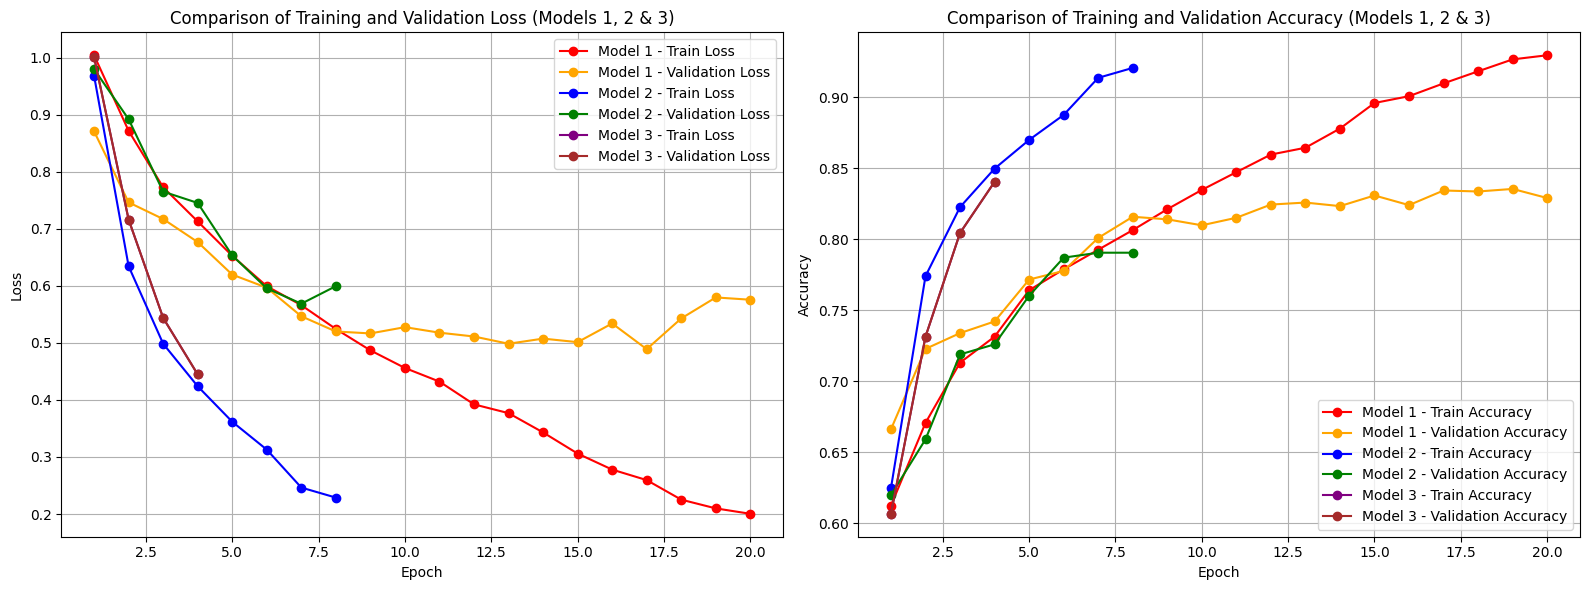

In [23]:
import matplotlib.pyplot as plt

# Model 1 (20 epochs)
epochs_model_1 = [i for i in range(1, 21)]
train_loss_1 = [1.0045, 0.8719, 0.7730, 0.7131, 0.6528, 0.5995, 0.5662, 0.5245, 0.4870, 0.4561, 0.4322, 0.3923, 0.3769, 0.3431, 0.3060, 0.2779, 0.2595, 0.2252, 0.2099, 0.2004]
val_loss_1 = [0.8711, 0.7465, 0.7173, 0.6769, 0.6198, 0.5969, 0.5468, 0.5201, 0.5167, 0.5277, 0.5180, 0.5113, 0.4986, 0.5076, 0.5014, 0.5342, 0.4891, 0.5430, 0.5798, 0.5758]
train_acc_1 = [0.6125, 0.6707, 0.7131, 0.7314, 0.7641, 0.7788, 0.7926, 0.8064, 0.8211, 0.8347, 0.8472, 0.8596, 0.8644, 0.8779, 0.8959, 0.9007, 0.9097, 0.9182, 0.9266, 0.9295]
val_acc_1 = [0.6662, 0.7228, 0.7339, 0.7421, 0.7716, 0.7777, 0.8009, 0.8158, 0.8140, 0.8098, 0.8151, 0.8244, 0.8258, 0.8233, 0.8308, 0.8240, 0.8343, 0.8336, 0.8354, 0.8290]

# Model 2 (8 epochs)
epochs_model_2 = [1, 2, 3, 4, 5, 6, 7, 8]
train_loss_2 = [0.9684, 0.6345, 0.4986, 0.4240, 0.3618, 0.3129, 0.2464, 0.2288]
val_loss_2 = [0.9802, 0.8923, 0.7654, 0.7455, 0.6534, 0.5958, 0.5688, 0.5996]
train_acc_2 = [0.6248, 0.7740, 0.8226, 0.8497, 0.8699, 0.8875, 0.9136, 0.9206]
val_acc_2 = [0.6199, 0.6591, 0.7189, 0.7260, 0.7602, 0.7870, 0.7905, 0.7905]

# Model 3 (4 epochs)
epochs_model_3 = [1, 2, 3, 4]
train_loss_3 = [1.0013, 0.7163, 0.5439, 0.4448]
val_loss_3 = [1.0013, 0.7163, 0.5439, 0.4448]
train_acc_3 = [0.6067, 0.7314, 0.8044, 0.8404]
val_acc_3 = [0.6067, 0.7314, 0.8044, 0.8404]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(epochs_model_1, train_loss_1, label='Model 1 - Train Loss', color='red', linestyle='-', marker='o')
ax1.plot(epochs_model_1, val_loss_1, label='Model 1 - Validation Loss', color='orange', linestyle='-', marker='o')
ax1.plot(epochs_model_2, train_loss_2, label='Model 2 - Train Loss', color='blue', linestyle='-', marker='o')
ax1.plot(epochs_model_2, val_loss_2, label='Model 2 - Validation Loss', color='green', linestyle='-', marker='o')
ax1.plot(epochs_model_3, train_loss_3, label='Model 3 - Train Loss', color='purple', linestyle='-', marker='o')
ax1.plot(epochs_model_3, val_loss_3, label='Model 3 - Validation Loss', color='brown', linestyle='-', marker='o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Comparison of Training and Validation Loss (Models 1, 2 & 3)')
ax1.legend()
ax1.grid(True)

ax2.plot(epochs_model_1, train_acc_1, label='Model 1 - Train Accuracy', color='red', linestyle='-', marker='o')
ax2.plot(epochs_model_1, val_acc_1, label='Model 1 - Validation Accuracy', color='orange', linestyle='-', marker='o')
ax2.plot(epochs_model_2, train_acc_2, label='Model 2 - Train Accuracy', color='blue', linestyle='-', marker='o')
ax2.plot(epochs_model_2, val_acc_2, label='Model 2 - Validation Accuracy', color='green', linestyle='-', marker='o')
ax2.plot(epochs_model_3, train_acc_3, label='Model 3 - Train Accuracy', color='purple', linestyle='-', marker='o')
ax2.plot(epochs_model_3, val_acc_3, label='Model 3 - Validation Accuracy', color='brown', linestyle='-', marker='o')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Comparison of Training and Validation Accuracy (Models 1, 2 & 3)')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.show()

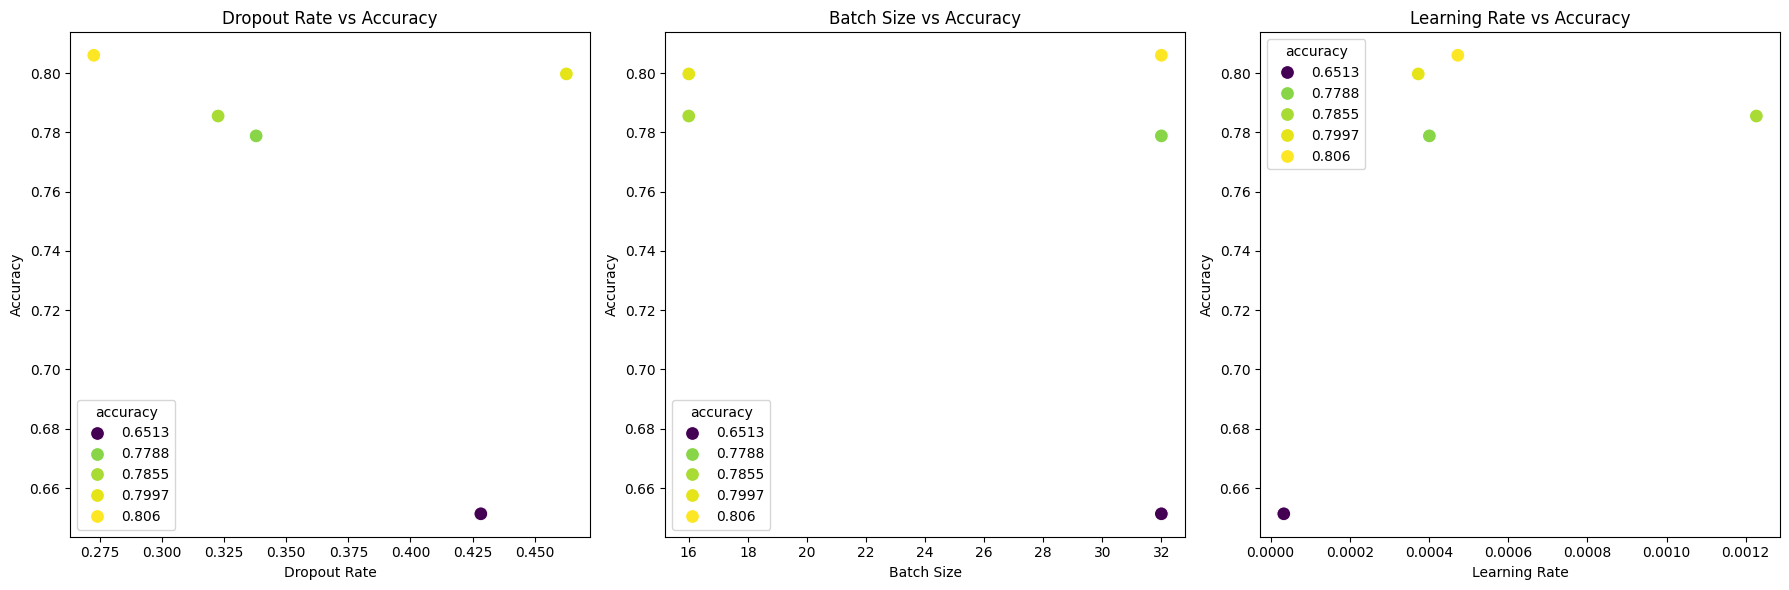

In [25]:
# результати з optuna для демонстрації залежності між різними значеннями гіперпараметрів та точністю моделів.
results = {
    'dropout_rate': [0.4627, 0.3379, 0.2726, 0.3226, 0.4283],
    'batch_size': [16, 32, 32, 16, 32],
    'lr': [0.0003729, 0.000401, 0.0004729, 0.001227, 3.322e-5],
    'epochs': [3, 3, 4, 3, 4],
    'accuracy': [0.7997, 0.7788, 0.8060, 0.7855, 0.6513]
}

df = pd.DataFrame(results)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# dropout_rate
sns.scatterplot(data=df, x='dropout_rate', y='accuracy', ax=axes[0], hue='accuracy', palette='viridis', s=100)
axes[0].set_title('Dropout Rate vs Accuracy')
axes[0].set_xlabel('Dropout Rate')
axes[0].set_ylabel('Accuracy')

# batch_size
sns.scatterplot(data=df, x='batch_size', y='accuracy', ax=axes[1], hue='accuracy', palette='viridis', s=100)
axes[1].set_title('Batch Size vs Accuracy')
axes[1].set_xlabel('Batch Size')
axes[1].set_ylabel('Accuracy')

# lr
sns.scatterplot(data=df, x='lr', y='accuracy', ax=axes[2], hue='accuracy', palette='viridis', s=100)
axes[2].set_title('Learning Rate vs Accuracy')
axes[2].set_xlabel('Learning Rate')
axes[2].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

**ВИСНОВОК**

* Першим етапом оптимізації був ручний підхід, де ми обирали значення для learning rat та кількість згорткових шарів. Прийшли до висновку, що додавання шару позитивно вплнуло на модель, а розмір learning rate 0.0001 найкращий у нашому випадку.

* Пошук найкращих параметріва з Optuna зайняло значний час, але допомогло знайти золоту середину для тренування моделі, що підкреслює важливість вибору відповідних параметрів для зменшення часу навчання.

* Модель, оптимізована за допомогою Optuna, показала значне покращення в порівнянні з попередньою моделлю (з 3 шарами та 20 епохами). Зокрема, ми отримали точність 0.8060 на валідаційних даних, що є кращим результатом, ніж попередні 0.7997.

* Результати невеликого дослідження на залежність від гіперпараметрів показали, що не всі значення приносять однакові результати ( наприклад, зміна одного параметра може призводити до значних змін ).

